# Inference: Classical and Bayesian

G. Richards 
(2016, 2018, 2020),
with material from Ivezic [Sections 4.0, 4.1, 4.2, 4.3, 4.5, 5.0, 5.1, 5.2], Bevington, and Leighly.  With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s21).

## Contents
* [Statistical Inference](#one)
* [Maximum Likelihood Estimation](#two)
* [MLE Applied To A Homoscedastic Gaussian](#three)
* [Quantifying Estimate Uncertainty](#four)
* [Confidence Intervals](#five)
* [MLE Applied To A Heteroscedastic Gaussian](#six)
* [Aside: Cost Functions](#seven)
* [Goodness of Fit](#eight)
* [Bayesian Statistical Inference](#nine)
* [Bayesian Priors](#ten)
* [Heteroscedastic Gaussian with Bayesian Priors](#eleven)
* [Stuff that there simply won't be time for!](#twelve) 

## Statistical Inference <a class="anchor" id="one"></a>

Statistical **inference** is about drawing conclusions from data, specifically determining the properties of a population by data sampling.  

Three examples of inference are:
* What is the best estimate for a model parameter?
* How confident we are about our result?
* Are the data consistent with a particular model/hypothesis?

### Some Terminology

* We typically study the properties of some ***population*** by measuring ***samples*** from that population. 
* A ***statistic*** is any function of the sample. For example, the sample mean is a statistic. But also, "the value of the first measurement" is also a statistic.
* To conclude something about the population from the sample, we develop ***estimators***. An estimator is a statistic based on observed data.
* There are ***point*** and ***interval estimators***. Point estimators yield single-valued results (example: the position of an object), while with an interval estimator, the result would be a range of plausible values (example: confidence interval for the position of an object).
* Measurements have **uncertainties** (not errors) and we need to account for these (sometimes they are unknown).

### Frequentist vs. Bayesian Inference

There are two major statistical paradigms that address the statistical inference questions: 
- the **classical**, or **frequentist** paradigm,
- the **Bayesian** paradigm.

While most of statistics and machine learning is based on the classical paradigm, Bayesian techniques are being embraced by the statistical and scientific communities at an ever-increasing pace...especially in astrophysics.

For more insight see [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

#### Key differences
- **Definition of probabilities**:
    - In ***frequentist inference***, probabilities describe the ***relative frequency of events*** over repeated experimental trials. 
    - In ***Bayesian infernece***, probabilities instead quantify our ***subjective belief about experimental outcomes, model parameters, or even models themselves***. 
    
In short, classical (frequentist) statistics is concerned with the frequency with which $A$  happens in identical repeats of an experiment, i.e., $p(A)$. Bayesian statistics is concerned instead with $p(A|B)$, which is how plausible it is for $A$ to happen given the knowledge that $B$ has happened (or is true).     
    
- **Quantifying uncertainty**:
    - In ***frequentist inference*** we have ***confidence levels*** that describe the distribution of the measured parameter from the data around the true value.
    - In ***Bayesian inference*** we have ***credible regions*** derived from posterior probabilitiy distributions (we'll meet these later). These encode our "***belief spread***" in model parameters. 

My colleague, Karen Leighly, dug up the following article, which might help one to understand the differences in these approaches in a relatively simply way.  The first 4 sections are what is relevant here.
[Efron 1978](http://www.jstor.org/stable/2321163?seq=1#page_scan_tab_contents)

I'll briefly (and perhaps too cavalierly) summarize it.

Let's say that you get the results of an IQ test.  Any given test result might not give you your "real" IQ.  But it gives us a way to *estimate* it (and the possible range of values).  

For a frequentist, the best estimator is just the average of many test results.  So, if you took 5 IQ tests and got a 160, then that would be the estimator of your true IQ.

On the other hand, a Bayesian would say: "but wait, I know that IQ tests are normed to 100 with a standard deviation of 15 points".  So they will use that as "prior" information, which is important here since 160 is a 4$\sigma$ outlier. 

In [2]:
# Execute this cell
%matplotlib inline
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt


<font color='red'>Complete and execute the following cell. It will show the simple average of IQ tests, the prior distribution one would use in a Bayesian analysis, and the final Bayesian posterior "belief" distribution.</font>

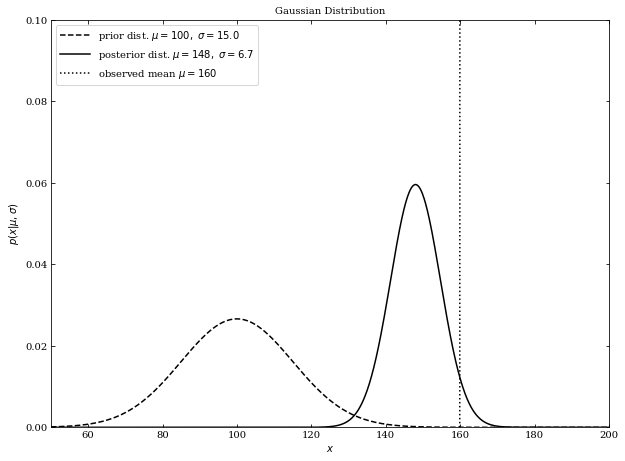

In [3]:
#------------------------------------------------------------
# Define the distributions to be plotted
sigma_values = [15, 6.7, 1] #complete with the prior width of IQ distribution
linestyles = ['--', '-', ':']
mu_values = [100, 148, 160] #complete with the prior mean of IQ distribution
labeltext = ['prior dist.', 'posterior dist.', 'observed mean']
xplot = np.linspace(50, 200, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))

for sigma, ls, mu, lab in zip(sigma_values, linestyles, mu_values, labeltext):
    # create a gaussian / normal distribution
    dist = norm(mu, sigma)

    if (sigma>1):
        plt.plot(xplot, dist.pdf(xplot), ls=ls, c='black',label=r'%s $\mu=%i,\ \sigma=%.1f$' % (lab, mu, sigma))
    else:
        plt.plot([159.9,160.1],[0,0.8], ls=ls, color='k', label=r'%s $\mu=%i$' % (lab, mu))
        
plt.xlim(50, 200)
plt.ylim(0, 0.1)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()

The end result (skipping over the detailed math) is that the Bayesian estimate of the IQ is not 160, but rather 148, or more specifically that $p(141.3\le \mu \le 154.7 \, | \, \overline{x}=160) = 0.683$.

That's actually fine, where the controvery comes in is when the Bayesian wants to do the same things but doesn't actually know the prior distribution, or when the parameter is fixed but we are trying to experimentally verify it (e.g., the speed of light).

## Maximum Likelihood Estimation (MLE), Ivezic 4.2  <a class="anchor" id="two"></a>

Let's not worry about classical vs. Bayesian right now and talk about maximum likelihood estimation (Ivezic, 4.2), which is relevant to both.

Maximum likelihood estimation follows this blueprint:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, the data are a measurement of some quantity with Gaussian random uncertainties (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.


2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta^0}$.


3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta^0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation (we'll come to these later).


4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

### Example: Measuring the Position of a Quasar

Let's assume we wish to estimate the position $x$ of a quasar from a series of individual astrometric measurements.

1. We adopt a model where the observed quasar does not move, and has individual measurement uncertainties 
2. We derive the expression for the likelihood of there being a quasar at position $x_0$ that gives rise to our individual measurements. We find the value of $\hat x_0$ for which our observations are maximally likely.
3. We determine the uncertainties (confidence intervals) on our measurement.
4. We test whether what we've observed is consistent with our adopted model. For example, is it possible that the quasar was really a misidentified star with measurable proper motion?

Note: in the text to come, I will use $\mu$ instead of $x_0$ to denote the true position of the quasar. This is to avoid potential confusion with the first (or zeroth) measurement of $x$.

If we know the distribution from which our data were drawn, then we can compute the **probability** of our data.  

For example if you know that your data are drawn from a model with a Gaussian distribution, then we've already seen that the probablity of getting a specific value of $x$ is given by
$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$

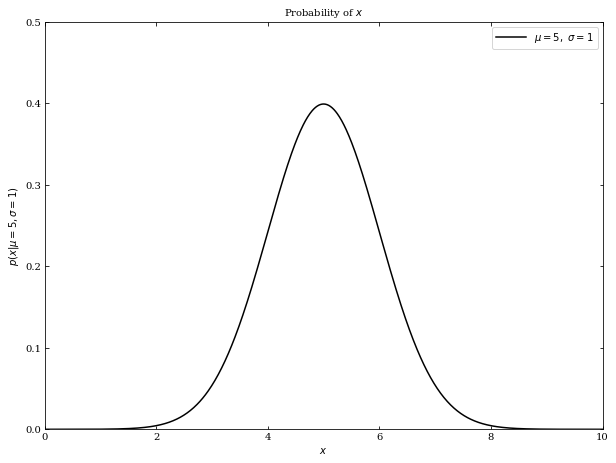

In [4]:
# Execute this cell
#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(10, 7.5))
dist = norm(5, 1)
x = np.linspace(0, 10, 1000)
plt.plot(x, dist.pdf(x), c='black',label=r'$\mu=5,\ \sigma=1$')

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu=5,\sigma=1)$')
plt.title('Probability of $x$')

plt.legend()

If we want to know the total **likelihood** of our *entire* data set (as opposed to one measurement) then we must compute the *product* of all the individual probabilities:
$$L \equiv p(\{x_i\}|M(\theta)) = \prod_{i=1}^n p(x_i|M(\theta)),$$
where $M$ refers to the *model* and $\theta$ refers collectively to the $k$ parameters of the model, which can be multi-dimensional.

In words, this is *the probability of the data given the model*.  However, note that while the components of $L$ may be normalized pdfs, their product is not.  Also the product can be very small, so we often take the log of $L$.

We can write this out as
$$L = \prod_{i=1}^n \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$
and simplify to
$$L = \prod_{i=1}^n \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right),$$

where we have written the product of the exponentials as the exponential of the sum of the arguments, which will make things easier to deal with later.

That is, we have done this: $$\prod_{i=1}^n A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_n) \exp[-(B_i+B_{i+1}+\ldots+B_n)]$$

If you have done $\chi^2$ analysis (e.g., doing a linear least-squares fit), then you might notice that the argument of the exponential is just 
$$\exp \left(-\frac{\chi^2}{2}\right).$$

That is, for our gaussian distribution
$$\chi^2 = \sum_{i=1}^n \left ( \frac{x_i-\mu}{\sigma}\right)^2.$$

So, maximizing the likelihood is the same as minimizing $\chi^2$.  In both cases we are finding the most likely values of our model parameters (here $\mu$ and $\sigma$).  

### The Key Idea Behind Maximum Likelihood Estimation

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters), then MLE is about varying the parameters until we find the maximal value of $L$ (i.e., the **maximum likelihood**).  Those model parameters will also minimize $\chi^2$, and will be our *Maximum Likelihood Estimators* for for the true values of the model. 

Simple as that.  Stop and make sure that you understand this.

Here's [an animation of linear least squares fitting](https://yihui.org/animation/example/least-squares/).

They are trying to fit a line to some data.  They start by fixing the interecept and then trying 50 different values of the slope.  The red dashed lines show the difference (*residual*) between the predicted value and the actual value.  These are squared and summed (residual sum of squares, or $\chi^2$) and plotted as the y axis in the right hand plot.  You see $\chi^2$ going down as the slope changes, bottoming out at the best slope (presumably with $\chi^2 \sim 1$, but we can't tell from the scale shown).  Then $\chi^2$ goes back up after we have passed through the best slope.

With the best slope determined, we then try different values of the intercept, choosing the one that minimizes $\chi^2$.

A simple example would be the likelihood of rolling a certain combination of numbers on a six-sided die.
The probability of rolling a 3 is $1/6$ (as is the probability of *any* roll).  So, what is the probability of rolling (in no particular order): {1,1,2,3,3,3,4,5,6,6}?  

In [5]:
print((1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6)*(1./6))
print((1./6)**10)

1.6538171687920194e-08
1.6538171687920194e-08


So, even for 10 rolls of the die, the likelihood is pretty small.  That's just because there are *lots* of possible combinations of rolling a die 10 times.  This particular series of numbers is just as likely as any other.  

Students who took PHYS 114 with me will recall that the result is related to the number of *combinations* ($n$ choose $r$).

In [6]:
# Write some code to compute the probability for N rolls
import numpy as np
N=10 #Number of rolls
L=1 #Likelihood, initialize to unity
rolls = np.array([])
for i in np.arange(N): #Loop over each roll
    #Append a single new roll to "rolls" between 1 and 6 (careful) to the rolls array
    rolls = np.append(rolls,np.random.randint(low=1,high=7,size=1))
    L = L*(1./6) #The likelihood of each roll is 1/6
print(L,rolls)

1.6538171687920194e-08 [3. 1. 3. 5. 2. 5. 4. 5. 4. 5.]


## MLE applied to a Homoscedastic Gaussian (Ivezic 4.2.3)  <a class="anchor" id="three"></a>

Let's take a look at an example using a Gaussian model where all the measurements have the same error ($\sigma$).  This is known as having **homoscedastic** errors.  Don't be intimidated by the fancy word, statisticians just like to sound smart, so they say "homoscedastic" instead of "uniform errors".  Later we will consider the case where the measurements can have different errors ($\sigma_i$) which is called **heteroscedastic**.

For an experiment with data $D=\{x_i\}$ in 1D with Gaussian errors, we have
$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Note that that is $p(\{x_i\})$ not $p(x_i)$, that is the probability of the full data set, not just one measurement.

If $\sigma$ is both constant and *known*, then this is a one parameter model with $k=1$ and $\theta_1=\mu$. 

As we found above, likelihoods can be really small, so let's define the **log-likelihood function** as ${\rm lnL} = \ln[L(\theta)]$.  The maximum of this function happens at the same place as the maximum of $L$.  Note that any constants in $L$ have the same effect for all model parameters, so constant terms can be ignored.  

In this case we then have $${\rm lnL} = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Take a second and make sure that you understand how we got there.  It might help to remember that above, we wrote
$$L = \prod_{i=1}^n \left( \frac{1}{\sigma\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma} \right]^2 \right).$$

We then determine the maximum in the same way that we always do.  It is the parameter set for which the derivative of ${\rm lnL}$ is zero:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\mu_0} \equiv 0.$$

That gives $$ \sum_{i=1}^N \frac{(x_i - \mu_o)}{\sigma^2} = 0.$$

Since $\sigma = {\rm constant}$ (at least in this case), that says 
$$\sum_{i=1}^N x_i = \sum_{i=1}^N \mu_0 = N \mu_0.$$

Thus we find that
$$\mu_0 = \frac{1}{N}\sum_{i=1}^N x_i,$$
which is just the arithmetic mean of all the measurements.

As promised last week, that's where the formula that you know and love for the mean comes from.  

### The Sample Mean is an ML Estimator

So the **sample mean** ($\overline{x} = \mu_0$) of observations drawn from a $\mathscr{N}(\mu, \sigma=const)$ distribution is a maximum-likelihood **estimator** of the distribution's $\mu$ parameter.  We'd intuitively guess that, but this derivation clarifies our choice.

As we just discussed, in an experiment with data $D=\{x_i\}$ in 1D with Gaussian errors, we have
$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Let's create some data and see what the resulting likelihood looks like for some example points.

In [7]:
#Load up the algorithms we are going to need.
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
%matplotlib inline

We are going to draw a homoscedastic sample of ${x_i}$ from a Gaussian and compute the likelihood.

First generate a sample of `N=3` points drawn from a normal distribution with `mu=1.0` and `sigma=0.2`: $\mathscr{N}(\mu,\sigma)$

In [8]:
N = 3 #Complete
mu = 1
sigma = 0.2 
np.random.seed(42)
sample = norm(mu,sigma).rvs(N)
print(sample)

[1.09934283 0.97234714 1.12953771]


Think back to Lecture 2 when we did a Kernel Density Estimate.  Treat each of those observations as an estimate of the true distribution.  So, we are going to center a Gaussian (with the known $\sigma$) at each point, this is the likelihood $p(x_i|\mu,\sigma)$.

Plot each of the likelihoods separately.  Also plot their product.  Make the $x$ axis a grid of 1000 points uniformly sampled between $x=0$ and $x=2$.

Note that, according to [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), `norm.pdf(x, loc, scale)` is identically equivalent to `norm.pdf(y)/scale` with `y=(x-loc)/scale$`.

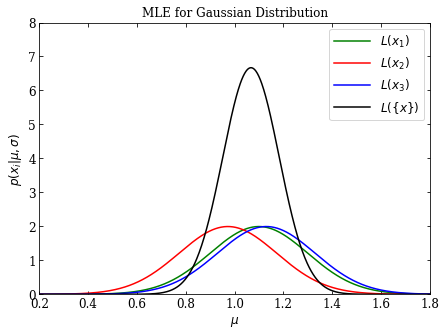

In [20]:
#Make the plot and see if you get the same as me.
xgrid = np.linspace(0,2,1000)
L1 = norm.pdf(xgrid,loc=sample[0],scale=sigma) #This is a Gaussian PDF sampled uniformly, centered at a specific location.
L2 = norm.pdf(xgrid,loc=sample[1],scale=sigma)
L3 = norm.pdf(xgrid,loc=sample[2],scale=sigma)
L = L1*L2*L3 #Total L is ???

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(xgrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(xgrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(xgrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

You should get something that looks like this:
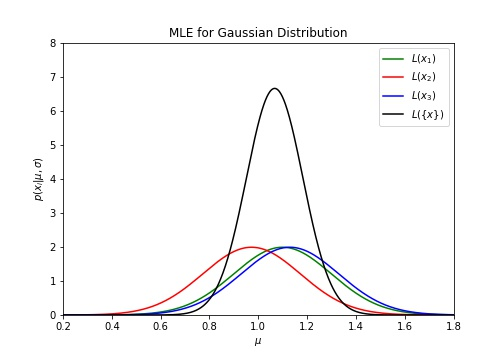

Now we can just read off the maximum likelihood solution.  Use `np.argsort()` to figure out the argument of the largest value and print that index of `xgrid`.

In [21]:
indices = np.argsort(L)
index_max = indices[-1]
print("Likelihood is maximized at %.3f" % xgrid[index_max])

Likelihood is maximized at 1.067


## Quantifying Estimated Uncertainty (Ivezic 4.2.5)  <a class="anchor" id="four"></a>

Our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the likelihood function, but we'd like to quantify it with a few numbers.

We *define* the uncertainty on our MLEs as second (partial) derivatives of log-likelihood:

$$\sigma_{jk} = \left( - \frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\theta_0}\right)^{-1/2}.$$

The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$, of this **covariance matrix**.

In our example, the uncertainly on the mean is 
$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\mu_0}\right)^{-1/2}$$

We find
$$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\mu_0} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$
since, again, $\sigma = {\rm constant}$.  

Then $$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is the result that we are already familiar with.

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor series and retaining terms up to second order (essentially, $\ln L$ is approximated by a parabola, or an ellipsoidal surface in multidimensional cases, around its maximum). If this expansion is exact (as is the case for a Gaussian error distribution), then we've completely captured the error information.

In general, this is not the case and the likelihood surface can significantly deviate from a smooth elliptical surface. Furthermore, it often happens in practice that the likelihood surface is multimodal. It is always a good idea to visualize the likelihood surface when in doubt (see examples in §5.6 in the textbook).

## Confidence Intervals <a class="anchor" id="five"></a>

The $(\mu_0 - \sigma_\mu, \mu_0 + \sigma_\mu)$ range gives us a **confidence interval**.

In frequentist interptetation, if we repeated the same measurement a hundred times, we'd find that 68 experiments yield a result within the computed confidence interval ($1 \sigma$ errors).

### Confidence Estimates: Bootstrap and Jackknife (Ivezic 4.5)

We often assume that the distribution is Gaussian and our samples are large, but even if that is not the case, we can still compute good confidence intervals (e.g., $a<x<b$ with 95\% confidence) using *resampling* strategies.

Remember that we have a data set $\{x_i\}$ from which we have estimated the distribution as $f(x)$ for a true distribution $h(x)$.  

In **bootstrapping** we map the uncertainty of the parameters by re-sampling from our distribution (with replacement) $B$ times, such that we obtain $B$ measures of our parameters.   So, if we have $i=1,\dots,N$ data points in $\{x_i\}$, we draw $N$ of them to make a new sample, where some values of $\{x_i\}$ will be used more than once.

The **jackknife** method is similar except that we don't use a sample size of $N$, rather we leave off one or more of the observations from $\{x_i\}$.  As with bootstrap, we do this multiple times, generating samples from which we can determine our uncertainties.

### When to bootstrap or jackknife?

- Jackknife estimates are usually easier to calculate, easier to apply for complex sampling schemes, and automtically remove bias.
- Bootstrap is better for computing confidence intervals because it maps out the full distribution of the statistic instead of assuming asymptotic normality.
- Bootstrap is random resampling so gives different results each time. Whereas jackknifing gives repeatable results.

It is generally a good idea to use both methods and compare the results. Use either/both with caution with $N$ is small!

An example of bootstrap is given below, using [astroML.resample.bootstrap](http://www.astroml.org/modules/generated/astroML.resample.bootstrap.html), where the arguments are 1) the data, 2) the number of bootstrap resamples to use, and 3) the statistic to be computed.

You'll get some more practice with this in a homework assignment based on Data Camp.

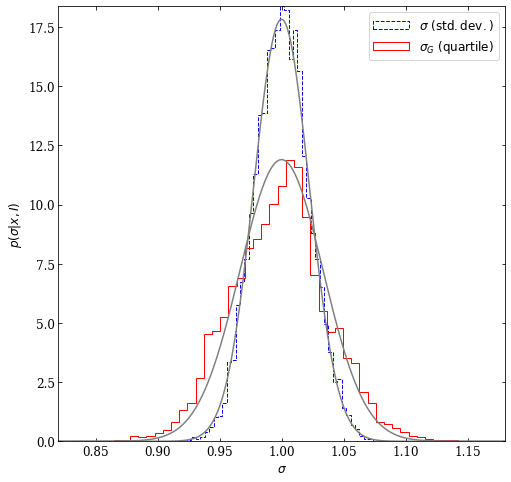

In [17]:
# Ivezic v2, Figure 4.3, modified slightly by GTR
# %load ../code/fig_bootstrap_gaussian.py
"""
Bootstrap Calculations of Error on Mean
---------------------------------------
Figure 4.3.

The bootstrap uncertainty estimates for the sample standard deviation
:math:`\sigma` (dashed line; see eq. 3.32) and :math:`\sigma_G` (solid line;
see eq. 3.36). The sample consists of N = 1000 values drawn from a Gaussian
distribution with :math:`\mu = 0` and :math:`\sigma = 1`. The bootstrap
estimates are based on 10,000 samples. The thin lines show Gaussians with
the widths determined as :math:`s / \sqrt{2(N - 1)}` (eq. 3.35) for
:math:`\sigma` and :math:`1.06 s / \sqrt{N}` (eq. 3.37) for :math:`\sigma_G`.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

from astroML.resample import bootstrap
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

m = 1000  # number of points
n = 10000  # number of bootstraps

#------------------------------------------------------------
# sample values from a normal distribution
np.random.seed(123)
data = norm(0, 1).rvs(m)

#------------------------------------------------------------
# Compute bootstrap resamplings of data
mu1_bootstrap = bootstrap(data, n, np.std, kwargs=dict(axis=1, ddof=1))
mu2_bootstrap = bootstrap(data, n, sigmaG, kwargs=dict(axis=1))

#------------------------------------------------------------
# Compute the theoretical expectations for the two distributions
xgrid = np.linspace(0.8, 1.2, 1000)

sigma1 = 1. / np.sqrt(2 * (m - 1))
pdf1 = norm(1, sigma1).pdf(xgrid)

sigma2 = 1.06 / np.sqrt(m)
pdf2 = norm(1, sigma2).pdf(xgrid)

#------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(mu1_bootstrap, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (std. dev.)}$')
ax.plot(xgrid, pdf1, color='gray')

ax.hist(mu2_bootstrap, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma_G\ {\rm (quartile)}$')
ax.plot(xgrid, pdf2, color='gray')

ax.set_xlim(0.82, 1.18)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|x,I)$')

ax.legend()

plt.show()

From Ivezic: "The bootstrap uncertainty estimates for the sample standard deviation $\sigma$ (dashed line; see Eq. 3.32) and $\sigma_G$ (solid line; see Eq. 3.36). The sample consists of N = 1000 values drawn from a Gaussian distribution with $\mu = 0$ and $\sigma = 1$. The bootstrap estimates are based on 10,000 samples. The thin grey lines show Gaussians with the widths determined as $s / \sqrt{2(N - 1)}$ (Eq. 3.35) for $\sigma$ and $1.06 s / \sqrt{N}$ (Eq. 3.37) for $\sigma_G$."

## MLE applied to a Heteroscedastic Gaussian (Ivezic 4.2.6) <a class="anchor" id="six"></a>

Now let's look at a case where the errors are heteroscedastic.  For example if we are measuring the length of a [rod](https://www.nist.gov/image/meter27jpg) and have $N$ measurements, $\{x_i\}$, where the error for each measurement, $\sigma_i$ is known.  Since $\sigma$ is **not** a constant, then following the above, we have

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\mu_0} = \sum_{i=1}^N \frac{(x_i - \mu_o)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\mu_o}{\sigma_i^2},$$

yields a MLE solution of 
$$\mu_0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

which is just a variance-weighted mean, with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$




## Aside: Cost Functions <a class="anchor" id="seven"></a>

Recall from Lecture 3 that we measured the deviation from expected in three different ways
$$d_i = x_i - \mu,$$  
$$|x_i-\mu|,$$
and
$$(x_i-\mu)^2.$$

When trying to determine the best model parameters, we have to specify a "cost function", which is basically the prescription for evaluating the difference (distance) between our estimator and the true value.  This is otherwise known as the "norm", or the total length of the distances.  The first form above represents the $L_0$ norm, while the next two are the $L_1$ norm (the "taxi-cab" norm) and the $L_2$ norm (the "as the crow flies" norm).  

So far we have been using an $L_2$ norm (which comes about simply from the definition of a Gaussian with the $(x_i-\mu)^2$ term).  Later in the course we will encounter machine learning algorithms that allow us to specify different norms (different cost functions).

See [this Medium article](https://medium.com/@montjoile/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c) and Ivezic, 4.2.8.

### Truncated/Censored Data

Note that knowing how to deal with missing data points ("censored data") is often quite important, but adds complications that we don't have time to get into here.  For more, see Ivezic 4.2.7.

## "Goodness" of Fit (Ivezic 4.3)  <a class="anchor" id="eight"></a>

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is.  If the model is wrong, "best" might not be particularly revealing ("Garbage In = Garbage Out")!  For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial.  But that won't help you predict future measurements.

We can describe the **goodness of fit** as 
> whether or not it is likely to have obtained $\ln L_0$ by randomly drawing from the data.  That means that we need to know the *distribution* of $\ln L$ and not just the maximum.  

For the Gaussian case we have just described, we do a standard transform of variables and compute the so-called $z$ score for each data point (basically the number of standard deviations away from the mean that this point is), writing 
$$z_i = (x_i-\mu)/\sigma,$$ then
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

Here, $\chi^2$ is the thing whose distribution we discussed last week.

So for Gaussian uncertainties, $\ln L$ is distributed as $\chi^2$.  

The peak Q value for 1 degrees of freedom is 0.00.
The peak Q value for 2 degrees of freedom is 0.00.
The peak Q value for 5 degrees of freedom is 3.00.
The peak Q value for 7 degrees of freedom is 5.00.


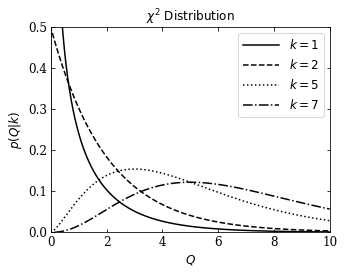

In [19]:
# Execute this cell to make the plot
# %load ../code/fig_chi2_distribution.py
"""
Example of a chi-squared distribution
---------------------------------------
Figure 3.14.

This shows an example of a :math:`\chi^2` distribution with various parameters.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import chi2
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Define the distribution parameters to be plotted
k_values = [1, 2, 5, 7]
linestyles = ['-', '--', ':', '-.']
mu = 0
xplot = np.linspace(-1, 10, 1000)

#------------------------------------------------------------
# plot the distributions
fig, ax = plt.subplots(figsize=(5, 3.75))
fig.subplots_adjust(bottom=0.12)

for k, ls in zip(k_values, linestyles):
    dist = chi2(k, mu)
    idx = np.argsort(dist.pdf(xplot))[-1]
    #print(f"The peak Q value for {k} degrees of freedom is {xplot[idx]}.")
    print("The peak Q value for {0:d} degrees of freedom is {1:3.2f}.".format(k,xplot[idx]))
                                                                                       
    plt.plot(xplot, dist.pdf(xplot), ls=ls, c='black',
             label=r'$k=%i$' % k)

plt.xlim(0, 10)
plt.ylim(0, 0.5)

plt.xlabel('$Q$')
plt.ylabel(r'$p(Q|k)$')
plt.title(r'$\chi^2\ \mathrm{Distribution}$')

plt.legend()
plt.show()

The mean of the $\chi^2$ distribution is $N-k$ and its standard deviation is $\sqrt{2(N-k)}$.

We define the $\chi^2$ per degree of freedom, $\chi^2_{dof}$, as
$$\chi^2_{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

For a good fit, we would expect that $\chi^2_{dof}\approx 1$.  If $\chi^2_{dof}$ is significantly larger than 1, then it is likely that we are not using the correct model.

We can also get overly high or low values of $\chi^2_{dof}$ if our errors are under- or over-estimated as shown below:

![Ivezic, Figure 4.1](http://www.astroml.org/_images/fig_chi2_eval_1.png)

## Bayesian Statistical Inference (Ivezic 5.0, 5.1)  <a class="anchor" id="nine"></a>

Up to now in this lecture we have been computing the **likelihood** $p(D|M)$.  In Bayesian inference, we instead evaluate the **posterior probability** taking into account **prior** information.

Recall from the BasicStats lecture that Bayes' Rule is:
$$p(M|D) = \frac{p(D|M)p(M)}{p(D)},$$
where $D$ is for data and $M$ is for model.

We wrote this in words as:
$${\rm Posterior Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

If we explicitly recognize prior information, $I$, and the model parameters, $\theta$, then we can write:
$$p(M,\theta|D,I) = \frac{p(D|M,\theta,I)p(M,\theta|I)}{p(D|I)},$$
where we can omit the explict dependence on $\theta$ by writing $M$ instead of $M,\theta$ where appropriate.  

Note that it is often that case that $p(D|I)$ is not evaluated explictly since the likelihood can be normalized such that the "evidence" is unity.

The Bayesian Statistical Inference process is then
* formulate the likelihood, $p(D|M,\theta,I)$, which is what we have been talking about so far today
* chose a prior, $p(M,\theta|I)$, which incorporates other information beyond the data in $D$
* determine the posterior pdf, $p(M,\theta|D,I)$
* search for the model paramters that maximize the posterior pdf
* quantify the uncertainty of the model parameter estimates
* test the hypothesis being addressed

How does our answer change for our earlier example if we include a Bayesian prior (like we assumed for the IQ problem) and instead maximize the posterior probability?

In [ ]:
#Things that we have already done above, but need to reset here
N = 3 #Complete
mu = 1.0
sigma = 0.2 
np.random.seed(42)
sample = norm(mu,sigma).rvs(N)

xgrid = np.linspace(0,2,1000)
L1 = norm.pdf(xgrid,loc=sample[0],scale=sigma)
L2 = norm.pdf(xgrid,loc=sample[1],scale=sigma)
L3 = norm.pdf(xgrid,loc=sample[2],scale=sigma)

#New things
Prior = norm.pdf(___,loc=___,scale=___) #Prior PDF
Post1 = ___*___ #Posterior PDF for the first measurement
Post2 = ___*___
Post3 = ___*___
Post = ___ #Total posterior PDF for all the measurements

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, Post1, ls='-', c='green', label=r'$P(x_1)$')
plt.plot(xgrid, ____, ls='-', c='red', label=r'$P(x_2)$')
plt.plot(xgrid, ____, ls='-', c='blue', label=r'$P(x_3)$')
plt.plot(xgrid, Post/5, ls='-', c='black', label=r'$P(\{x\})$') #Scaled for the sake of display

plt.xlim(0.2, 1.8)
plt.ylim(0, 10.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(\mu,\sigma|x_i)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show()

idx = np.argsort(Post)
print("Posterior PDF is maximized at %.3f" % xgrid[idx[-1]])

See what happens when you have just 2 measurements, but one has a much larger error than the other (i.e., the errors are heteroscedastic).

In [ ]:
L1 = norm.pdf(xgrid,loc=___,scale=___) #Measurement with small error
L2 = norm.pdf(xgrid,loc=___,scale=___) #Measurement with large error (give it a very different location parameter)
L = L1 * L2 
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, L1, ls='-', c='green', label=r'$L(x_1): good$')
plt.plot(xgrid, L2, ls='-', c='red', label=r'$L(x_2): lousy$')
plt.plot(xgrid, L, ls='-', c='black', label=r'$L(\{x\}): weighted$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 9.5)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Weighted measurements (not normalized)')
plt.legend()

idx = np.argsort(L)
print("Likelihood is maximized at %.3f" % xgrid[idx[-1]])

## Bayesian Priors (Ivezic 5.2)  <a class="anchor" id="ten"></a>

Priors can be **informative** or **uninformative**.  As it sounds, informative priors are based on existing information that might be available.  Uninformative priors can be thought of as "default" priors, i.e., what your prior is if you weren't explicitly including a prior, e.g, a "flat" prior like $p(\theta|M,I) \propto {\rm C}$.

For the IQ test example, what kind of prior did we use?

In a *hierarchical Bayesian* analysis the priors themselves can have parameters and priors (hyperparameters and hyperpriors), but let's not worry about that for now.

While determining good priors is important for Bayesian analysis, I don't want to get distracted by it here.  You can read more about it in Ivezic, 5.2.  However, I'll briefly introduce 3 principles here.

#### The Principle of Indifference

Essentially this means adopting a uniform prior, though you have to be a bit careful.  Saying that an asteroid is equally likely to hit anywhere on the Earth is not the same as saying that all latitudes of impact are equally likely.  Assuming $1/6$ for a six-side die would be an example of indifference.

#### The Principle of Invariance (or Consistency)

This applies to location and scale invariance.  Location invariance suggests a uniform prior (within the accepted bounds).  Scale invariance gives us priors that look like $p(A|I) \propto 1/A$.

#### The Principle of Maximum Entropy

The principle of maximum entropy is discussed in Ivezic, 5.2.2.
It is often true that Bayesian analysis and traditional MLE are essentially equivalent.  However, in some cases, considering the priors can have significant consequences. 
See Ivezic $\S$5.5 for such an example.

## Analysis of a Heteroscedastic Gaussian distribution with Bayesian Priors (Ivezic 5.6)  <a class="anchor" id="eleven"></a>

Consider the case of measuring a rod as above.  We want to know the posterior pdf for the length of the rod, $p(M,\theta|D,I) = p(\mu|\{x_i\},\{\sigma_i\},I)$.

For the likelihood we have
$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

In the Bayesian case, we also need a prior.  We'll adopt a uniform distribution given by
$$p(\mu|I) = C, \; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max},$$
where $C = \frac{1}{\mu_{\rm max} - \mu_{\rm min}}$ between the min and max and is $0$ otherwise.

The log of the posterior pdf is then
$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

This is exactly the same as we saw before, except that the value of the constant is different.  Since the constant doesn't come into play, we get the same result as before:
 
$$\mu^0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$
with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

We get the same result because we used a flat prior.  In the case of homoscedastic instead of heteroscedastic, we obviously would get the result from our first example.

Now let's consider the case where $\sigma$ is not known, but rather needs to be determined from the data.  In that case, the posterior pdf that we seek is not $p(\mu|\{x_i\},\{\sigma_i\},I)$, but rather $p(\mu,\sigma|\{x_i\},I)$.

As before we have
$$L = p(\{x_i\}|\mu,\sigma,I) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right),$$
except that now $\sigma$ is uknown instead of given (meaning we need to move it to the left of the "pipe").

Our Bayesian prior is now 2D instead of 1D and we'll adopt 
$$p(\mu,\sigma|I) \propto \frac{1}{\sigma},\; {\rm for} \; \mu_{\rm min} < \mu < \mu_{\rm max} \; {\rm and} \; \sigma_{\rm min} < \sigma < \sigma_{\rm max}.$$

That is, all values of $\mu$ are equally likely (within the range indicated), but we'll down-weight the likelihood of large errors (again limiting $\sigma$ to some range).  Note that the ranges actually drop out since they are constants.

With proper normalization, we have
$$p(\{x_i\}|\mu,\sigma,I)p(\mu,\sigma|I) = C\frac{1}{\sigma^{(N+1)}}\prod_{i=1}^N \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2}  \right),$$
where
$$C = (2\pi)^{-N/2}(\mu_{\rm max}-\mu_{\rm min})^{-1} \left[\ln \left( \frac{\sigma_{\rm max}}{\sigma_{\rm min}}\right) \right]^{-1}.$$



The log of the posterior pdf is

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma^2}.$$

Right now that has $x_i$ in it, which isn't that helpful, but since we are assuming a Gaussian distribution, we can take advantage of the fact that the mean, $\overline{x}$, and the variance, $V (=s^2)$, completely characterize the distribution.  So we can write this expression in terms of those variables instead of $x_i$.  Skipping over the math details (see Ivezic $\S$5.6.1), we find

$$\ln[p(\mu,\sigma|\{x_i\},I)] = {\rm constant} - (N+1)\ln\sigma - \frac{N}{2\sigma^2}\left( (\overline{x}-\mu)^2 + V  \right).$$

Note that this expression only contains the 2 parameters that we are trying to determine: $(\mu,\sigma)$ and 3 values that we can determine directly from the data: $(N,\overline{x},V)$.

Load and execute the next cell to visualize the posterior pdf for the case of $(N,\overline{x},V)=(10,1,4)$.  Change `usetex=True` to `usetex=False` if you have trouble with the plotting.  Try changing the values of $(N,\overline{x},V)$.

In [ ]:
# Execute this cell
# %load code/fig_likelihood_gaussian.py
"""
Log-likelihood for Gaussian Distribution
----------------------------------------
Figure5.4
An illustration of the logarithm of the posterior probability density
function for :math:`\mu` and :math:`\sigma`, :math:`L_p(\mu,\sigma)`
(see eq. 5.58) for data drawn from a Gaussian distribution and N = 10, x = 1,
and V = 4. The maximum of :math:`L_p` is renormalized to 0, and color coded as
shown in the legend. The maximum value of :math:`L_p` is at :math:`\mu_0 = 1.0`
and :math:`\sigma_0 = 1.8`. The contours enclose the regions that contain
0.683, 0.955, and 0.997 of the cumulative (integrated) posterior probability.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

The shaded region is the posterior probability.  The contours are the confidence intervals.  We can compute those by determining the marginal distribution at each $(\mu,\sigma)$.  The top panels of the figures below show those marginal distributions.  The solid line is what we just computed.  The dotted line is what we would have gotten for a uniform prior--not that much difference.  The dashed line is the MLE result, which is quite different.  The bottom panels show the cumulative distribution.

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_posterior_gaussian_1.png)


Note that the marginal pdfs follow a Student's $t$ Distribution, which becomes Gaussian for large $N$.

### Recap

To review: the Bayesian Statistical Inference process is
* formulate the likelihood, $p(D|M,\theta,I)$
* chose a prior, $p(M,\theta|I)$, which incorporates other information beyond the data in $D$
* determine the posterior pdf, $p(M,\theta|D,I)$
* search for the model paramters that maximize the posterior pdf
* quantify the uncertainty of the model parameter estimates
* test the hypothesis being addressed

The last part we haven't talked about yet.

What if we wanted to model the mixture of a Gauassian distribution with a uniform distribution.  When might that be useful?  Well, for example:

![Atlas Higgs Boson Example](https://atlas.cern/sites/atlas-public.web.cern.ch/files/Higgsmass_fig1_comb.jpg)

Obviously this isn't exactly a Gaussian and a uniform distribution, but a line feature superimposed upon a background is the sort of thing that a physicist might see and is pretty close to this case for a local region around the feature of interest.  This is the example discussed in Ivezic $\S$5.6.5.

For this example, we will assume that the location parameter, $\mu$, is known (say from theory) and that the errors in $x_i$ are negligible compared to $\sigma$.

The likelihood of obtaining a measurement, $x_i$, in this example can be written as
$$L = p(x_i|A,\mu,\sigma,I) = \frac{A}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right) + \frac{1-A}{W}.$$

Here the background probability is taken to be $0 < x < W$ and 0 otherwise.  The feature of interest lies between $0$ and $W$.  $A$ and $1-A$ are the relative strengths of the two components, which are obviously anti-correlated.  Note that there will be covariance between $A$ and $\sigma$.  

If we adopt a uniform prior in both $A$ and $\sigma$:
$$p(A,\sigma|I) = C, \; {\rm for} \; 0\le A<A_{\rm max} \; {\rm and} \; 0 \le \sigma \le \sigma_{\rm max},$$
then the posterior pdf is given by
$$\ln [p(A,\sigma|\{x_i\},\mu,W)] = \sum_{i=1}^N \ln \left[\frac{A}{\sigma \sqrt{2\pi}} \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2} \right)  + \frac{1-A}{W} \right].$$

The figure below (Ivezic, 5.13) shows an example for $N=200, A=0.5, \sigma=1, \mu=5, W=10$.  Specifically, the bottom panel is a result drawn from this distribution and the top panel is the likelihood distribution derived from the data in the bottom panel.
![Ivezic, Figure 5.13](http://www.astroml.org/_images/fig_likelihood_gausslin_1.png)

A more realistic example might be one where all three parameters are unknown: the location, the width, and the background level.  But that will have to wait until $\S$5.8.6.

In the meantime, note that we have not binned the data, $\{x_i\}$.  We only binned Figure 5.13 for the sake of visualizaiton.  However, sometimes the data are inherently binned (e.g., the detector is pixelated).  In that case, the data would be in the form of $(x_i,y_i)$, where $y_i$ is the number of counts at each location.  We'll skip over this example, but you can read about it in Ivezic $\S$5.6.6.  A refresher on the Poission distribution (Ivezic $\S$3.3.4) might be appropriate first.